# **Project 2 - Diabetes**
by Martin Tschechne, Han Bai, Nora Moser

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from xgboost import XGBClassifier

## **Exploratory Data Analysis & Feature Engineering**

In [147]:
data_train = pd.read_csv('../data/raw/10k_diabetes/diab_train.csv')
data_val = pd.read_csv('../data/raw/10k_diabetes/diab_validation.csv')
data_test = pd.read_csv('../data/raw/10k_diabetes/diab_test.csv')

For data exploration we look at the whole data set before we split again ...

In [148]:
data_train['type'] = 'train'
data_val['type'] = 'val'
data_test['type'] = 'test'
data = pd.concat([data_train,data_val,data_test],ignore_index=True)

In [149]:
data.T.head(50)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Unnamed: 0,9011,9569,6090,4282,9084,1776,797,413,8150,5317,...,996,8380,190,4132,1338,1262,9135,1339,3040,5437
race,AfricanAmerican,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Asian,...,Hispanic,Caucasian,Caucasian,Caucasian,Caucasian,?,Caucasian,AfricanAmerican,AfricanAmerican,Caucasian
gender,Male,Female,Female,Female,Male,Female,Male,Female,Male,Male,...,Female,Male,Female,Male,Female,Male,Male,Male,Male,Female
age,[60-70),[70-80),[80-90),[50-60),[80-90),[70-80),[60-70),[60-70),[20-30),[80-90),...,[30-40),[50-60),[80-90),[80-90),[40-50),[40-50),[80-90),[40-50),[50-60),[80-90)
weight,?,?,?,?,?,?,[75-100),?,?,?,...,?,?,?,?,?,?,?,?,?,?
admission_type_id,Emergency,Elective,Urgent,Emergency,Elective,Emergency,Elective,Emergency,Emergency,Urgent,...,Emergency,Urgent,Emergency,Emergency,Elective,Urgent,Not Available,Elective,Emergency,Elective
discharge_disposition_id,Discharged to home,NaN,Discharged/transferred to SNF,Discharged to home,NaN,Discharged/transferred to SNF,Discharged/transferred to ICF,Discharged to home,Discharged to home,Discharged/transferred to another short term h...,...,Discharged to home,Discharged to home,Discharged to home,Expired,NaN,Discharged to home,Discharged/transferred to SNF,NaN,Discharged to home,Discharged/transferred to another rehab fac in...
admission_source_id,Emergency Room,Physician Referral,Emergency Room,Emergency Room,Physician Referral,Emergency Room,Transfer from another health care facility,Transfer from a hospital,Emergency Room,Emergency Room,...,Emergency Room,Emergency Room,Emergency Room,Emergency Room,Transfer from a hospital,Transfer from a hospital,NaN,Physician Referral,Emergency Room,Physician Referral
time_in_hospital,4,1,2,4,13,3,5,3,2,1,...,6,3,12,7,10,1,6,4,2,1
payer_code,MC,?,MC,DM,?,?,MC,MC,?,SP,...,?,HM,MC,MC,?,UN,?,?,?,CM


We have categorical (e.g. gender), numerical (e.g. num_lab_procedures), ordinal features (e.g. ethnicity) and text (e.g. diag_1_desc)  
Lets take a look at our label distribution and No Information Rate. Later we will ise this value to compare our models with.

In [150]:
classes, counts = np.unique(data.readmitted.values, return_counts=True)
nir = np.max(counts/len(data))
print(f"Class {classes[0]}: {counts[0]*100/np.sum(counts)} %, Class {classes[1]}: {counts[1]*100/np.sum(counts)}%")
print(f"NIR: {nir * 100} %")

Class 0: 60.35 %, Class 1: 39.65%
NIR: 60.35 %


Have a look at missing values ...

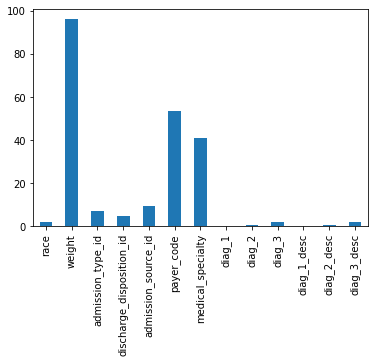

In [151]:
data.replace('?',np.nan,inplace=True)
nans = pd.Series(data.isna().sum()*100/len(data))
nans[nans != 0.0].plot.bar()

weight, payer_code and medical_specialty have over 40% missing values, thus we are dropping these features.

In [152]:
to_drop = ['weight','payer_code','medical_specialty','Unnamed: 0']
data.drop(to_drop,axis=1,inplace=True)

In [153]:
data[data['diag_1']=='250.01']['diag_1_desc']

395     Diabetes mellitus without mention of complicat...
1076    Diabetes mellitus without mention of complicat...
2184    Diabetes mellitus without mention of complicat...
3604    Diabetes mellitus without mention of complicat...
6546    Diabetes mellitus without mention of complicat...
7055    Diabetes mellitus without mention of complicat...
7364    Diabetes mellitus without mention of complicat...
9477    Diabetes mellitus without mention of complicat...
Name: diag_1_desc, dtype: object

Textual descriptions of ICD9 codes are the same for a specific code.

In [154]:
diag_text = data[['diag_1_desc','diag_2_desc','diag_3_desc']]
data.drop(['diag_1_desc','diag_2_desc','diag_3_desc'],axis=1,inplace=True)

Let's look at how many unique values we have in each feature:

In [155]:
to_drop = []
for k in data.keys():
    print(f"key: {k}: {len(data[k].unique())}")
    if len(data[k].unique()) == 1:
        to_drop.append(k)

key: race: 6
key: gender: 2
key: age: 10
key: admission_type_id: 7
key: discharge_disposition_id: 22
key: admission_source_id: 11
key: time_in_hospital: 14
key: num_lab_procedures: 108
key: num_procedures: 7
key: num_medications: 68
key: number_outpatient: 23
key: number_emergency: 12
key: number_inpatient: 11
key: diag_1: 458
key: diag_2: 430
key: diag_3: 461
key: number_diagnoses: 9
key: max_glu_serum: 4
key: A1Cresult: 4
key: metformin: 4
key: repaglinide: 4
key: nateglinide: 4
key: chlorpropamide: 3
key: glimepiride: 4
key: acetohexamide: 1
key: glipizide: 4
key: glyburide: 4
key: tolbutamide: 2
key: pioglitazone: 4
key: rosiglitazone: 4
key: acarbose: 3
key: miglitol: 4
key: troglitazone: 1
key: tolazamide: 2
key: examide: 1
key: citoglipton: 1
key: insulin: 4
key: glyburide.metformin: 4
key: glipizide.metformin: 2
key: glimepiride.pioglitazone: 1
key: metformin.rosiglitazone: 1
key: metformin.pioglitazone: 1
key: change: 2
key: diabetesMed: 2
key: readmitted: 2
key: type: 3


We see some features contain only one unique value, we drop those since they do not provide any useful information.

In [156]:
to_drop

['acetohexamide',
 'troglitazone',
 'examide',
 'citoglipton',
 'glimepiride.pioglitazone',
 'metformin.rosiglitazone',
 'metformin.pioglitazone']

In [157]:
data.drop(to_drop,axis=1,inplace=True)

In [158]:
data.keys()

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide.metformin', 'glipizide.metformin', 'change', 'diabetesMed',
       'readmitted', 'type'],
      dtype='object')

In [159]:
data.isna().sum()

race                        221
gender                        0
age                           0
admission_type_id           721
discharge_disposition_id    469
admission_source_id         936
time_in_hospital              0
num_lab_procedures            0
num_procedures                0
num_medications               0
number_outpatient             0
number_emergency              0
number_inpatient              0
diag_1                        2
diag_2                       59
diag_3                      208
number_diagnoses              0
max_glu_serum                 0
A1Cresult                     0
metformin                     0
repaglinide                   0
nateglinide                   0
chlorpropamide                0
glimepiride                   0
glipizide                     0
glyburide                     0
tolbutamide                   0
pioglitazone                  0
rosiglitazone                 0
acarbose                      0
miglitol                      0
tolazami

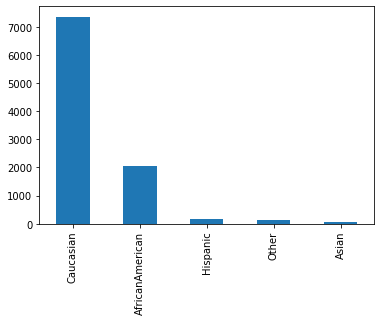

In [160]:
data.race.value_counts().plot.bar()

In [161]:
data.replace(np.nan,'?',inplace=True)

Impute race with median 'Caucasian'

In [162]:
data['race'].mode()

0    Caucasian
dtype: object

In [163]:
race_dict = {r:r for r in data['race'].unique()}
race_dict['?'] = 'Caucasian'
print(race_dict)
data['race'] = data.race.apply(lambda x: race_dict[x])

{'AfricanAmerican': 'AfricanAmerican', 'Caucasian': 'Caucasian', 'Asian': 'Asian', 'Other': 'Other', 'Hispanic': 'Hispanic', '?': 'Caucasian'}


In [164]:
for k in data.keys():
    print(f"key: {k}: {data[k].unique()}\n")

key: race: ['AfricanAmerican' 'Caucasian' 'Asian' 'Other' 'Hispanic']

key: gender: ['Male' 'Female']

key: age: ['[60-70)' '[70-80)' '[80-90)' '[50-60)' '[20-30)' '[40-50)' '[30-40)'
 '[10-20)' '[90-100)' '[0-10)']

key: admission_type_id: ['Emergency' 'Elective' 'Urgent' '?' 'Not Available' 'Not Mapped'
 'Newborn']

key: discharge_disposition_id: ['Discharged to home' '?' 'Discharged/transferred to SNF'
 'Discharged/transferred to ICF'
 'Discharged/transferred to another short term hospital' 'Not Mapped'
 'Discharged/transferred to home with home health service'
 'Discharged/transferred to another rehab fac including rehab units of a hospital.'
 'Discharged/transferred to another  type of inpatient care institution'
 'Discharged/transferred to a long term care hospital.' 'Expired'
 'Admitted as an inpatient to this hospital' 'Left AMA' 'Hospice / home'
 'Discharged/transferred to home under care of Home IV provider'
 'Hospice / medical facility'
 'Discharged/transferred/referred to a

Convert age classes into numerical values ...

In [165]:
age_dict = dict()
for i in range(10):
    age_dict[f"[{10*i}-{10*(i+1)})"] = 10*(i+0.5)
print(age_dict)

{'[0-10)': 5.0, '[10-20)': 15.0, '[20-30)': 25.0, '[30-40)': 35.0, '[40-50)': 45.0, '[50-60)': 55.0, '[60-70)': 65.0, '[70-80)': 75.0, '[80-90)': 85.0, '[90-100)': 95.0}


In [166]:
data['age'] = data.age.apply(lambda x: age_dict[x])

In [167]:
data.age.head()

0    65.0
1    75.0
2    85.0
3    55.0
4    85.0
Name: age, dtype: float64

Look at distributions of other features given the readmitted class ...

In [168]:
obj_keys = data.select_dtypes('object').keys().tolist()
obj_keys = [ok for ok in obj_keys if ok not in ['admission_type_id', 'discharge_disposition_id','admission_source_id', 'diag_1', 'diag_2', 'diag_3']]
print(obj_keys)

['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'change', 'diabetesMed', 'type']


/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


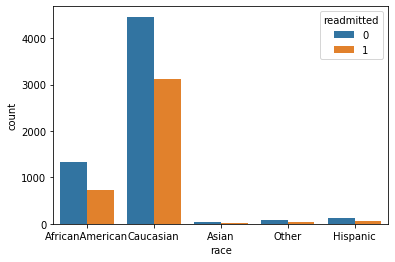

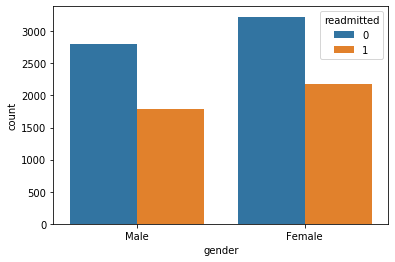

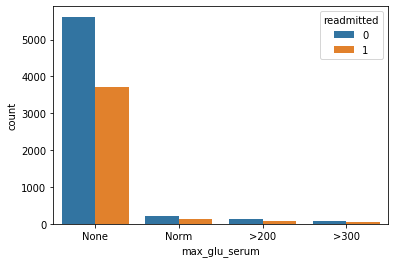

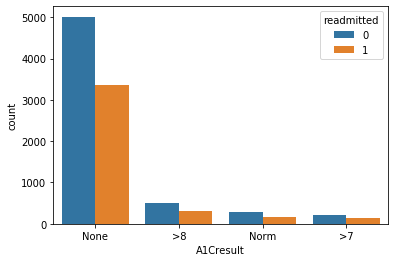

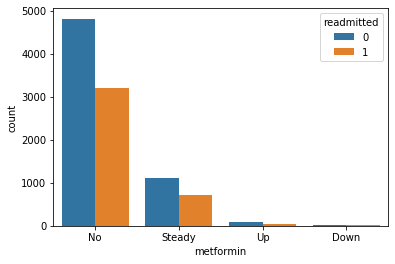

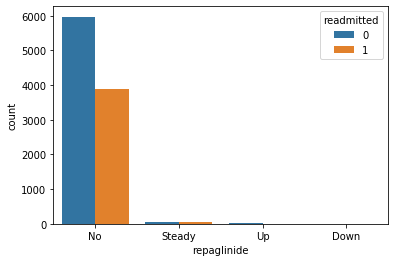

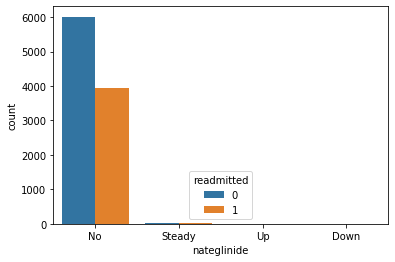

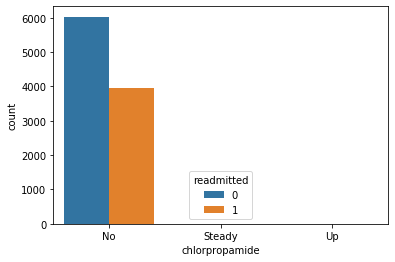

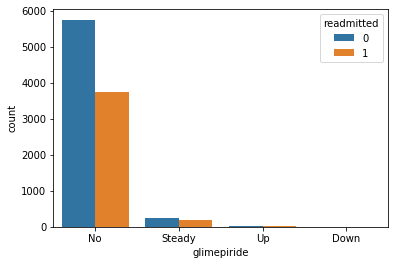

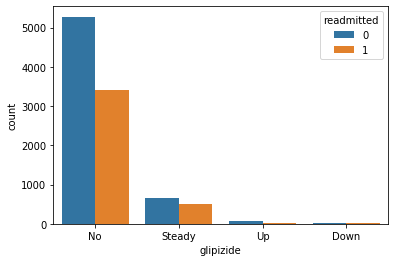

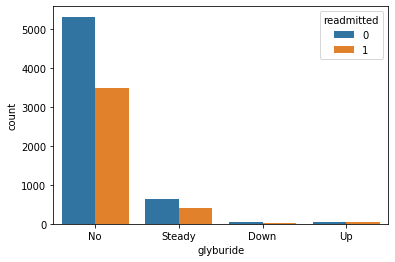

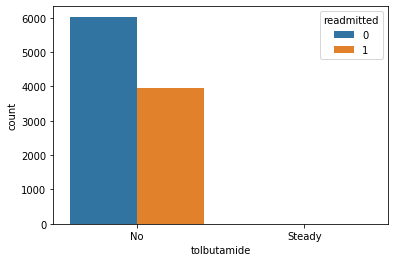

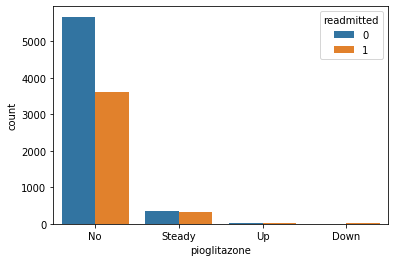

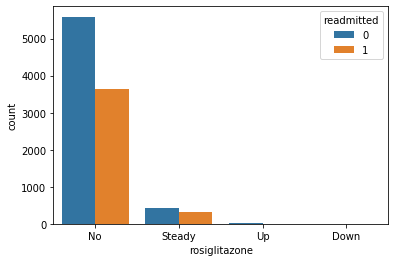

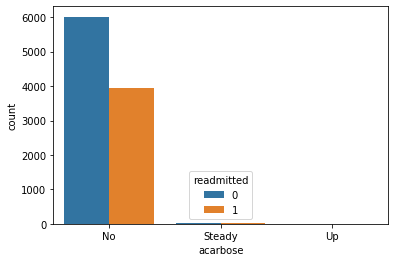

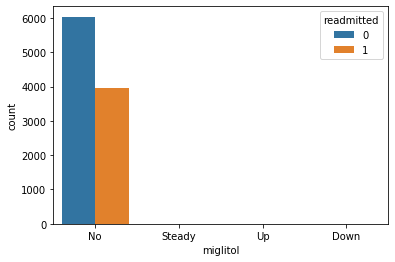

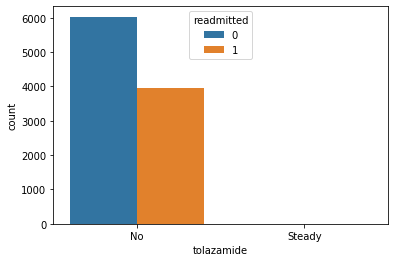

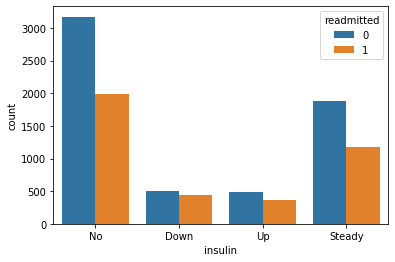

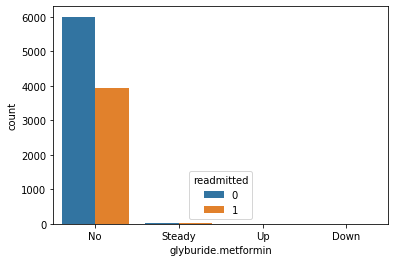

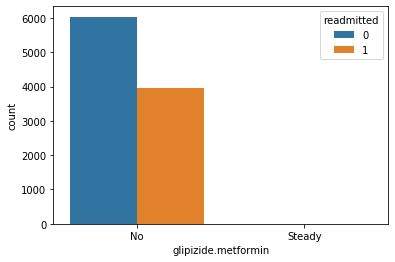

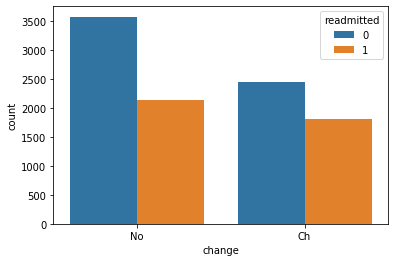

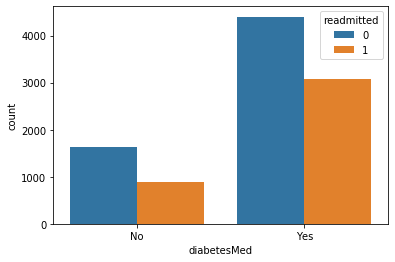

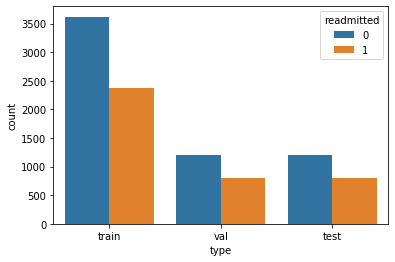

In [169]:
for k in obj_keys:
    plt.figure()
    sns.countplot(x=k,hue='readmitted',data=data)

Convert other categorical features into numericals ...

In [170]:
glu = {'None': 0,
       'Norm': 100,
       '>200': 200,
       '>300': 300 }
A1C = {'None':0,
      '>8':8,
      'Norm':5,
      '>7':7}
med = {'No':-20,
       'Steady':0,
       'Up':10,
       'Down':-10}
diaMed = {'No':-1,'Yes':1}
change = {'No':-1,'Ch':1}

In [171]:
data.max_glu_serum = data.max_glu_serum.apply(lambda x: glu[x])
data.A1Cresult = data.A1Cresult.apply(lambda x: A1C[x])
data.change = data.change.apply(lambda x: change[x])
data.diabetesMed = data.diabetesMed.apply(lambda x: diaMed[x])
for medication in ['metformin','repaglinide','nateglinide',
                    'chlorpropamide','glimepiride','glipizide','glyburide',
                    'tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',
                    'tolazamide','insulin','glyburide.metformin','glipizide.metformin']:
    data[medication] = data[medication].apply(lambda x : med[x])

Look at distributions of numerical features ...

In [172]:
num = data.select_dtypes('number').keys()
num = ['readmitted', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications']

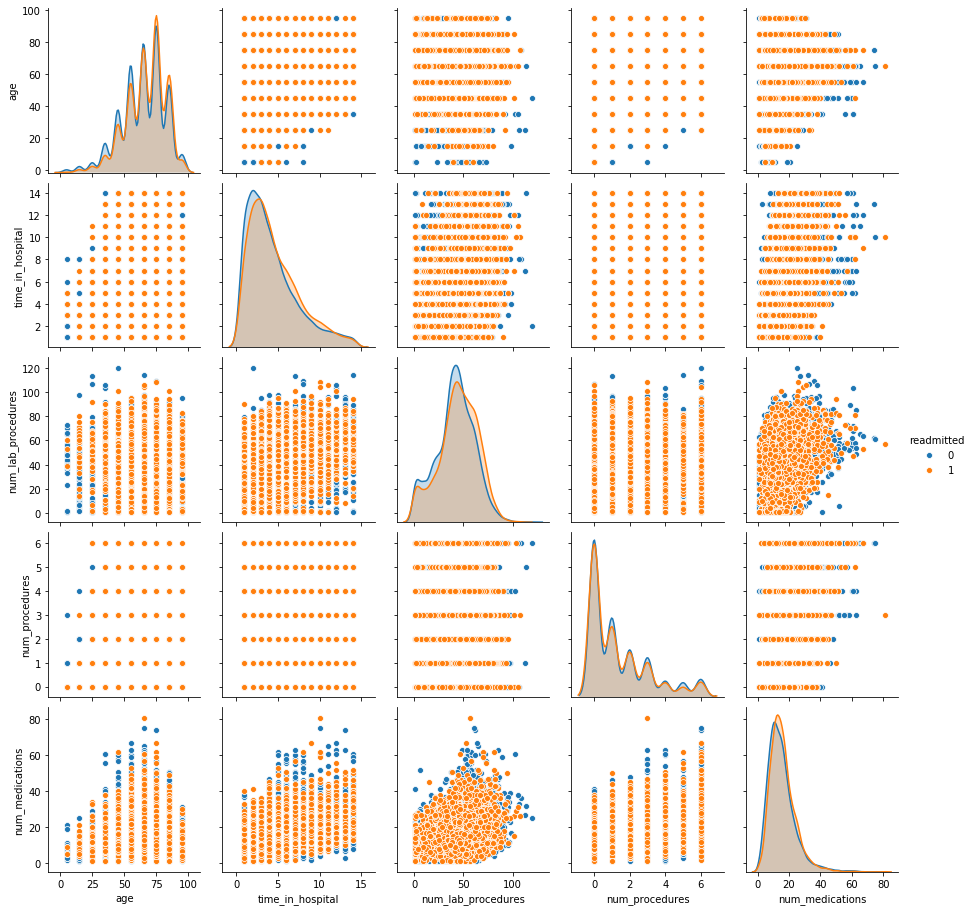

In [173]:
sns.pairplot(data[num],hue='readmitted')

As in the original paper, we group ICD9-codes into categories

In [174]:
def convert_icd9_codes(code):
    if '250.' in code:
        return 'diabetes'
    elif code[0] == 'E' or code[0] == 'V' or code == '?':
        return 'other'
    else:
        code = int(code)
        if code >= 390 and code <= 459 or code == 785:
            return 'circulatory'
        elif code >= 460 and code <= 519 or code == 786:
            return 'respiratory'
        elif code >= 520 and code <= 579 or code == 787:
            return 'degistive'
        elif code >= 800 and code <= 999:
            return 'injury'
        elif code >= 710 and code <= 739:
            return 'musculoskeletal'
        elif code >= 580 and code <= 629 or code == 788:
            return 'genitourinary'
        elif code >= 140 and code <= 239:
            return 'neoplasms'
        else:
            return 'other'

In [175]:
for diag in ['diag_1','diag_2','diag_3']:
    data[diag]=data[diag].apply(lambda x: convert_icd9_codes(x))

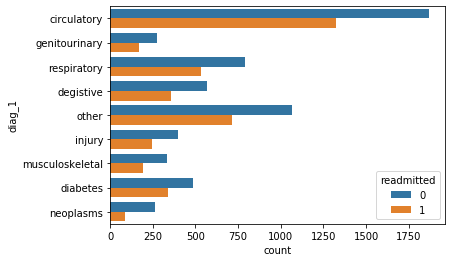

In [176]:
data['diag_1'].unique()
sns.countplot(y='diag_1',hue='readmitted',data=data,orient='h')

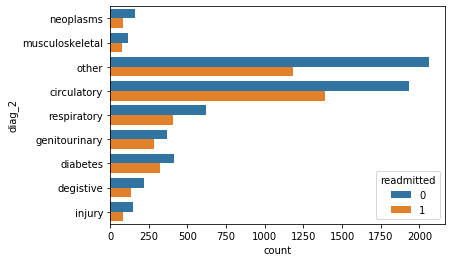

In [177]:
data['diag_2'].unique()
sns.countplot(y='diag_2',hue='readmitted',data=data,orient="h")

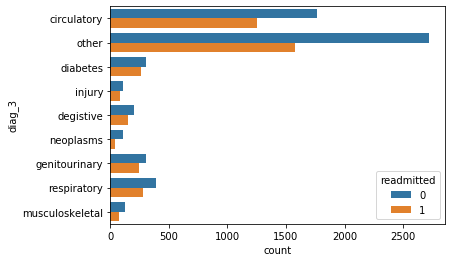

In [178]:
data['diag_3'].unique()
sns.countplot(y='diag_3',hue='readmitted',data=data,orient='h')

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 37 columns):
race                        10000 non-null object
gender                      10000 non-null object
age                         10000 non-null float64
admission_type_id           10000 non-null object
discharge_disposition_id    10000 non-null object
admission_source_id         10000 non-null object
time_in_hospital            10000 non-null int64
num_lab_procedures          10000 non-null int64
num_procedures              10000 non-null int64
num_medications             10000 non-null int64
number_outpatient           10000 non-null int64
number_emergency            10000 non-null int64
number_inpatient            10000 non-null int64
diag_1                      10000 non-null object
diag_2                      10000 non-null object
diag_3                      10000 non-null object
number_diagnoses            10000 non-null int64
max_glu_serum               10000 non-null int64


Split data again into train, validation and test set

In [179]:
train = data[data.type=='train']
y_train = train['readmitted']
train.drop(['readmitted','type'],axis=1,inplace=True)

val = data[data.type=='val']
y_val = val['readmitted']
val.drop(['readmitted','type'],axis=1,inplace=True)

test = data[data.type=='test']
y_test = test['readmitted']
test.drop(['readmitted','type'],axis=1,inplace=True)

/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [180]:
data_type = data['type']
data.drop(['type','readmitted'],axis=1,inplace=True)

Make remaining features ordinal 

In [221]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data)
train = ordinal_encoder.transform(train)
val = ordinal_encoder.transform(val)
test = ordinal_encoder.transform(test)

/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ValueError: Found unknown categories [-1.8732205996962286, -0.7227703618972243, 0.4276798759017798, 1.578130113700784, 2.728580351499788] in column 0 during transform

Normalize data

In [184]:
scaler = StandardScaler()
train = scaler.fit_transform(np.concatenate((train,val),axis=0))
test = scaler.transform(test)

In [185]:
y_train = np.concatenate((y_train,y_val),axis=0)

## **NLP for Diagnose**  
We convert the textual features into a vector representation in order to work with them. For this we use TF-IDF vectorization.

In [186]:
tfidf_vec = TfidfVectorizer(stop_words='english',ngram_range=(2,4),max_features=200)

In [187]:
diag_text.head()

,diag_1_desc,diag_2_desc,diag_3_desc
0,Acute pericarditis in diseases classified else...,Secondary malignant neoplasm of kidney,"Congestive heart failure, unspecified"
1,Malignant essential hypertension,"Spinal stenosis, unspecified region",Diabetes mellitus without mention of complicat...
2,"Urinary tract infection, site not specified",Streptococcus infection in conditions classifi...,"Congestive heart failure, unspecified"
3,"Respiratory abnormality, unspecified","Hypertensive chronic kidney disease, malignant...",Diabetes mellitus without mention of complicat...
4,Coronary atherosclerosis of unspecified type o...,"Chronic airway obstruction, not elsewhere clas...",Malignant essential hypertension


In [188]:
diag_text.isna().sum()

diag_1_desc      2
diag_2_desc     59
diag_3_desc    208
dtype: int64

In [189]:
diag_text.fillna('?',inplace=True)

/home/martin/miniconda3/envs/ml4h-p1-env/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [190]:
diag_text.isna().sum()

diag_1_desc    0
diag_2_desc    0
diag_3_desc    0
dtype: int64

In [191]:
corpus = diag_text['diag_1_desc'].tolist()+diag_text['diag_2_desc'].tolist()+diag_text['diag_3_desc'].tolist()
y_diag = np.array(data_type.tolist()+data_type.tolist()+data_type.tolist())
y_diag.shape

(30000,)

In [192]:
corpus = [c.replace(',','') for c in corpus]
corpus = [c.replace('/',' ') for c in corpus]

In [193]:
X = tfidf_vec.fit_transform(corpus)
X.shape

(30000, 200)

In [194]:
diag_train = X[(y_diag == 'train'),:].todense()
diag_val = X[(y_diag == 'val'),:].todense()
diag_train = np.concatenate([diag_train,diag_val],axis=0)
diag_test = X[(y_diag == 'test'),:].todense()

In [195]:
diag_train.shape, y_train.shape

((24000, 200), (8000,))

## **Feature Importance & Selection**
First we look at the feature importance of numerical / categorical with XGBoost

In [196]:
model = XGBClassifier(base_score=0.6035,booster='gbtree',max_depth=7,n_jobs=-1,random_state=42, n_estimators=100,metric='auc',subsample=0.7)
model.fit(train, y_train)

XGBClassifier(base_score=0.6035, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7, metric='auc',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [197]:
feat_import = sorted(zip(model.feature_importances_,data.keys().tolist(), np.int8(np.linspace(0,len(data.keys()),len(data.keys())+1))),reverse=True)

In [198]:
feat_import[:10]

[(0.08933195, 'number_inpatient', 12),
 (0.040410183, 'discharge_disposition_id', 4),
 (0.040296707, 'pioglitazone', 27),
 (0.039312083, 'number_emergency', 11),
 (0.038428407, 'number_diagnoses', 16),
 (0.036689784, 'repaglinide', 20),
 (0.03609399, 'glyburide.metformin', 33),
 (0.03348759, 'number_outpatient', 10),
 (0.032172557, 'admission_source_id', 5),
 (0.031897582, 'glimepiride', 23)]

In [ ]:
feat_import[:-10]

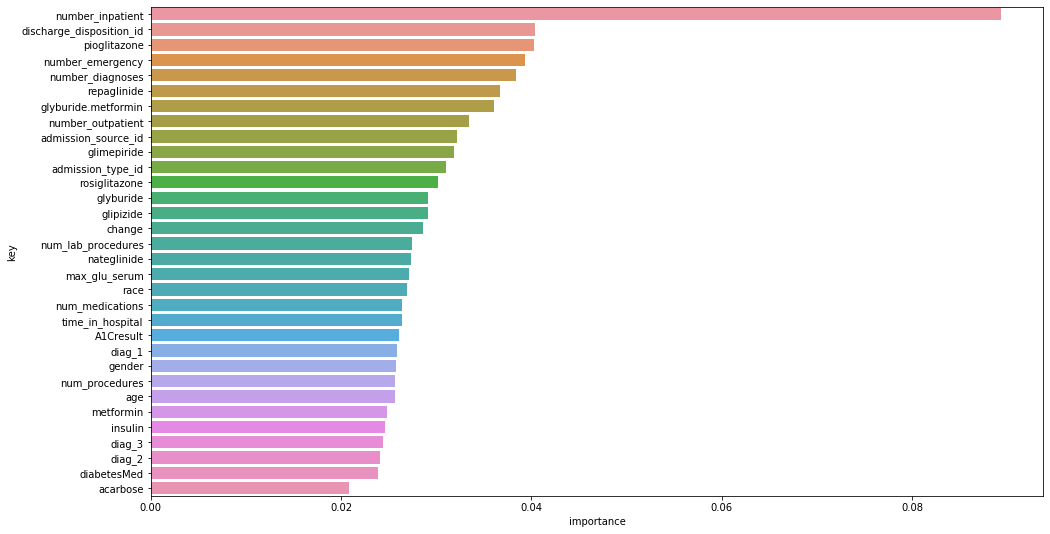

In [199]:
importance, key, num_idx = zip(*feat_import)
non_zero = np.array(importance) != 0
plot_df = pd.DataFrame({'importance':np.array(importance)[non_zero],
             'key':np.array(key)[non_zero],
             'idx':np.array(num_idx)[non_zero]})
plt.figure(figsize=(16,9))
sns.barplot(y='key',x='importance',data=plot_df)
plt.savefig('./visualization/num-cat-feature-importance.png',dpi=100)

We see that the number of inpatient stays has the most importance followed by discharge_disposition_id, number emergencies and number disgnoses

In [200]:
model = XGBClassifier(base_score=0.6035,booster='gbtree',max_depth=7,n_jobs=-1,random_state=42, n_estimators=100,metric='auc',subsample=0.7)
model.fit(diag_train, np.concatenate([y_train,y_train,y_train],axis=0))

XGBClassifier(base_score=0.6035, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7, metric='auc',
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [201]:
text_import = sorted(zip(model.feature_importances_,tfidf_vec.get_feature_names(), np.int32(np.linspace(0,len(tfidf_vec.get_feature_names()),len(tfidf_vec.get_feature_names())+1))),reverse=True)

In [202]:
text_import[:10]

[(0.033397563, 'mitral valve disorders', 122),
 (0.03149654, 'failure unspecified', 69),
 (0.028591998, 'malignant neoplasm', 104),
 (0.025299156, 'cerebral infarction', 23),
 (0.02470294, 'heart failure', 72),
 (0.023569748, 'complication unspecified', 41),
 (0.023102237, 'acute kidney', 2),
 (0.022180844, 'ii unspecified type stated', 80),
 (0.021957025, 'pulmonary collapse', 144),
 (0.021700794, 'type uncontrolled', 176)]

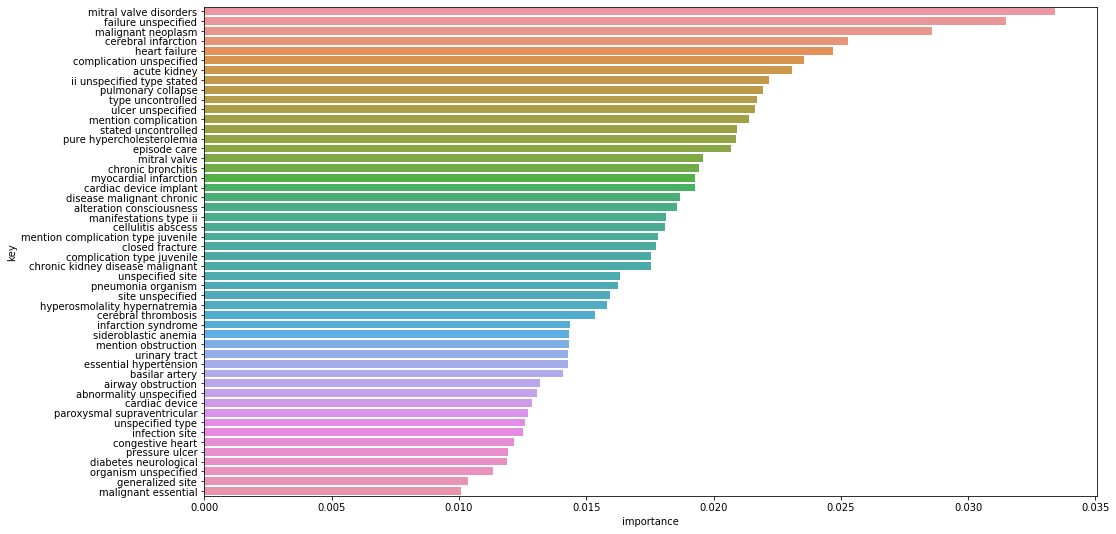

In [203]:
importance, key, idx = zip(*text_import)
non_zero = np.array(importance) != 0
plot_df = pd.DataFrame({'importance':np.array(importance)[non_zero][:50],
             'key':np.array(key)[non_zero][:50],
             'idx':np.array(idx)[non_zero][:50]})
plt.figure(figsize=(16,9))
sns.barplot(y='key',x='importance',data=plot_df)
plt.savefig('./visualization/text-feature-importance.png',dpi=100)

Specific disgnoses indicate a higher chance for readmittance. Those are linked to heart disease or organ failure.

## Modelling  
We try a plethora of different models to see how they perform ...

In [204]:
models = [('SVM linear',SVC(kernel='linear',random_state=42)),
         ('SVM rbf',SVC(kernel='rbf',random_state=42)),
         ('SVM poly',SVC(kernel='poly',random_state=42)),
         ('Logistic Regression', LogisticRegression(random_state=42,n_jobs=-1)),
         ('Random Forest', RandomForestClassifier(random_state=42)),
         ('XGBoost', XGBClassifier(base_score=0.6035,booster='gbtree',max_depth=10,n_jobs=-1,random_state=42, n_estimators=100,metric='f1_score',subsample=0.7)),
         ('MLP', MLPClassifier(random_state=42, early_stopping=True))]

First we compare numerical/categorical features against textual features:

In [205]:
for d, X, X_test in [('num/cat features',train, test),
                     ('text features',diag_train.reshape((8000,-1)),diag_test.reshape((2000,-1)))]:
    print(10*':::')
    print(d+':')
    for name, model in models:
        print(10*'---')
        print(name +':')
        model.fit(X,y_train)
        test_preds = model.predict(X_test)
        print(f"F1: {f1_score(y_test,test_preds,average='micro'):.3f}")
        print(f"AUROC: {roc_auc_score(y_test,test_preds):.3f}")
    print('\n')

::::::::::::::::::::::::::::::
num/cat features:
------------------------------
SVM linear:
F1: 0.626
AUROC: 0.546
------------------------------
SVM rbf:
F1: 0.647
AUROC: 0.584
------------------------------
SVM poly:
F1: 0.632
AUROC: 0.558
------------------------------
Logistic Regression:
F1: 0.629
AUROC: 0.568
------------------------------
Random Forest:
F1: 0.658
AUROC: 0.609
------------------------------
XGBoost:
F1: 0.654
AUROC: 0.620
------------------------------
MLP:
F1: 0.633
AUROC: 0.582


::::::::::::::::::::::::::::::
text features:
------------------------------
SVM linear:
F1: 0.602
AUROC: 0.500
------------------------------
SVM rbf:
F1: 0.592
AUROC: 0.498
------------------------------
SVM poly:
F1: 0.568
AUROC: 0.495
------------------------------
Logistic Regression:
F1: 0.589
AUROC: 0.494
------------------------------
Random Forest:
F1: 0.538
AUROC: 0.499
------------------------------
XGBoost:
F1: 0.584
AUROC: 0.498
------------------------------
MLP:
F1: 0.60

**Results**  
NIR = 0.6035  

|Model|Num./Cat. Features<br>n=37|Text Features<br>N=600|
|---|---|---|
|SVM (linear)|F1: 0.626<br>AUROC: 0.546|F1: 0.602<br>AUROC: **0.500**|
|SMV (rbf)|F1: 0.647<br>AUROC: 0.584|F1: 0.592<br>AUROC: 0.498|
|SMV (poly,d=3)|F1: 0.632<br>AUROC: 0.558|F1: 0.568<br>AUROC: 0.495|
|Log.Reg.|F1: 0.629<br>AUROC: 0.568|F1: 0.589<br>AUROC: 0.494|
|Random Forest|F1: **0.658**<br>AUROC: 0.609|F1: 0.538<br>AUROC: 0.499|
|XGBoost|F1: 0.654<br>AUROC: **0.620**|F1: 0.584<br>AUROC: 0.498|
|MLP|F1: 0.633<br>AUROC: 0.582|F1: **0.604**<br>AUROC: **0.500**|

Now we look at the performance of the models if only the most important features are selected and how the performance improves if we combine numerical/categorical and textual features.  

Take all text features with importance ...

In [206]:
print(sum(non_zero))
diag_filtered = (diag_train[:,non_zero]).reshape((8000,3*sum(non_zero)))
diag_filtered_test = (diag_test[:,non_zero]).reshape((2000,3*sum(non_zero)))
diag_filtered.shape, diag_filtered_test.shape

64


((8000, 192), (2000, 192))

Take the 10 most important numerical features ...

In [207]:
train_filtered = train[:,num_idx[:10]]
test_filtered = test[:,num_idx[:10]]
train_filtered.shape, test_filtered.shape

((8000, 10), (2000, 10))

Test performance ...

In [208]:
for d, X_filtered, X_filtered_test in [('num/cat features',train_filtered, test_filtered),
                                       ('text features',diag_filtered, diag_filtered_test),
                                       ('num/cat & text features',np.concatenate([diag_filtered, train_filtered],axis=1),
                                                                  np.concatenate([diag_filtered_test, test_filtered],axis=1))]:
    print(10*':::')
    print(d+':')
    for name, model in models:
        print(10*'---')
        print(name +':')
        model.fit(X_filtered,y_train)
        test_preds = model.predict(X_filtered_test)
        print(f"F1: {f1_score(y_test,test_preds,average='micro'):.3f}")
        print(f"AUROC: {roc_auc_score(y_test,test_preds):.3f}")
    print('\n')

::::::::::::::::::::::::::::::
num/cat features:
------------------------------
SVM linear:
F1: 0.626
AUROC: 0.546
------------------------------
SVM rbf:
F1: 0.638
AUROC: 0.582
------------------------------
SVM poly:
F1: 0.619
AUROC: 0.532
------------------------------
Logistic Regression:
F1: 0.626
AUROC: 0.562
------------------------------
Random Forest:
F1: 0.636
AUROC: 0.590
------------------------------
XGBoost:
F1: 0.644
AUROC: 0.595
------------------------------
MLP:
F1: 0.628
AUROC: 0.575


::::::::::::::::::::::::::::::
text features:
------------------------------
SVM linear:
F1: 0.604
AUROC: 0.501
------------------------------
SVM rbf:
F1: 0.594
AUROC: 0.501
------------------------------
SVM poly:
F1: 0.582
AUROC: 0.497
------------------------------
Logistic Regression:
F1: 0.599
AUROC: 0.497
------------------------------
Random Forest:
F1: 0.575
AUROC: 0.500
------------------------------
XGBoost:
F1: 0.594
AUROC: 0.501
------------------------------
MLP:
F1: 0.60

**Results with selected features**  
NIR = 0.6035

|Model|Num./Cat. Features<br>N=10|Text Features<br>N=192|Num./Cat. + Text Features<br>N=202|
|---|---|---|---|
|SVM (linear)|F1: 0.626<br>AUROC: 0.546|F1: **0.604**<br>AUROC: 0.501|F1: 0.626<br>AUROC: 0.547|
|SMV (rbf)|F1: 0.638<br>AUROC: 0.582|F1: 0.594<br>AUROC: 0.501|F1: **0.641**<br>AUROC: 0.585|
|SMV (poly,d=3)|F1: 0.619<br>AUROC: 0.532|F1: 0.582<br>AUROC: 0.497|F1: 0.615<br>AUROC: 0.529|
|Log.Reg.|F1: 0.626<br>AUROC: 0.562|F1: 0.599<br>AUROC: 0.497|F1: 0.618<br>AUROC: 0.554|
|Random Forest|F1: 0.636<br>AUROC: 0.590|F1: 0.575<br>AUROC: 0.500|F1: 0.613<br>AUROC: 0.579|
|XGBoost|F1: **0.644**<br>AUROC: **0.595**|F1: 0.594<br>AUROC: 0.501|F1: 0.634<br>**AUROC: 0.592**|
|MLP|F1: 0.628<br>AUROC: 0.575|F1: 0.603<br>AUROC: **0.503**|F1: 0.631<br>AUROC: 0.571|

## **Model Visualization**

In [270]:
pca = PCA(n_components=2,random_state=42)
tsne = TSNE(n_components=2,random_state=42,perplexity=5,n_iter=10000)

In [274]:
X_red = pca.fit_transform(diag_filtered_test)
#X_red = tsne.fit_transform(diag_filtered_test[:,:64])

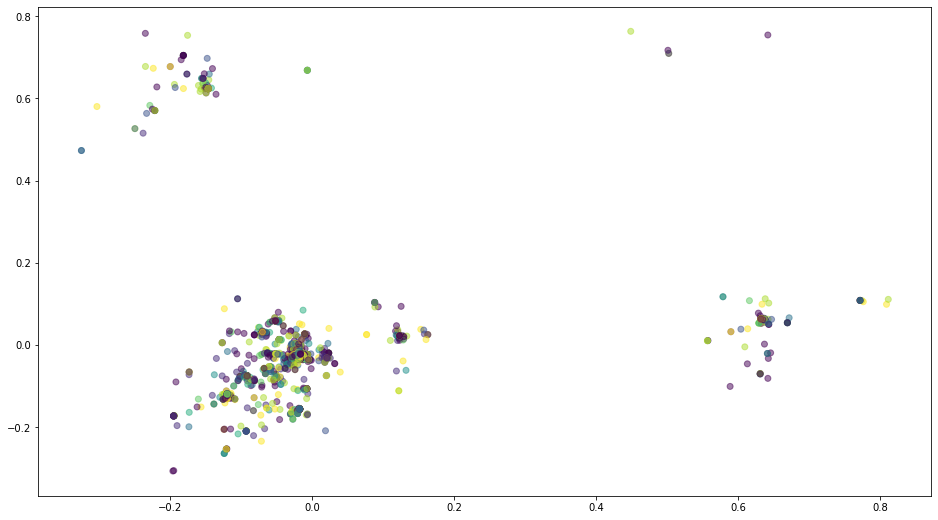

In [276]:
le = LabelEncoder()
diag_1 = le.fit_transform(data['diag_1'].to_numpy()[8000:])
diag_2 = data['diag_2']
diag_3 = data['diag_3']
plt.figure(figsize=(16,9))
plt.scatter(X_red[:,0],X_red[:,1],alpha=0.5,c=diag_1)

In [ ]:
df = pd.DataFrame({'dim1':X_red[:,0],
                  'dim2':X_red[:,1],
                  'class':y_train})
g = sns.PairGrid(df, diag_sharey=False, hue='class',height=5)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=1)